# 计算MA5

In [9]:
from WindPy import w
import pandas as pd
from datetime import datetime
w.start()
today = datetime.now().strftime("%Y-%m-%d")
close_df = w.wsd("AU.SHF", "close", "2010-01-01", today, "PriceAdj=F")
close_df = pd.DataFrame(close_df.Data, columns=close_df.Times, index=["close"]).T
close_df.index = pd.to_datetime(close_df.index)


Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [16]:
# 计算 5 日移动平均线
# close_df['MA5'] = close_df['close'].shift(1).rolling(window=5).mean()
close_df['MA5'] = close_df['close'].rolling(window=5).mean()
# 比较最后一个收盘价与最后一个 5 日均线，生成信号
close_df['signal'] = close_df['close'] > close_df['MA5']
close_df['signal'] = close_df['signal'].astype(int)  # 将 True/False 转换为 1/0

In [17]:
close_df.to_excel("gold_ma5_signal_old.xlsx")

In [ ]:
import pandas as pd
signal_df = pd.read_excel("gold_ma5_signal_old.xlsx")
def signal_generator(ma5_signal, cftc_signal,style):
  
    if style == 'conservative':  # 稳健型策略：综合考虑MA5和CFCT信号
        if ma5_signal == 1 and cftc_signal == 1:  # 双信号强，做全仓
            return 1
        elif ma5_signal == 1 and cftc_signal == 0.5:  # MA5强，CFCT中等强度，做半仓
            return 0.5
        elif ma5_signal == 1 and cftc_signal == 0:  # MA5强，CFCT弱，做四分之一仓
            return 0.25
        elif ma5_signal == 0 and cftc_signal == 1:  # MA5弱，CFCT强，做半仓
            return 0.5
        elif ma5_signal == 0 and cftc_signal == 0.5:  # 双信号弱，做四分之一仓
            return 0.25
        elif ma5_signal == 0 and cftc_signal == 0:  #   若CFCT为0则不操作
            return -1
        return 0

    elif style == 'neutral':  # 中性型策略：平衡两个信号
        if ma5_signal == 1 and cftc_signal == 1:  # 双信号强，做全仓
            return 1
        elif ma5_signal == 1 and cftc_signal == 0.5:  # MA5强，CFCT中等强度，做半仓
            return 0.5
        elif ma5_signal == 1 and cftc_signal == 0:  # MA5强，CFCT弱，做四分之一仓
            return 0.25
        elif ma5_signal == 0 and cftc_signal == 1:  # MA5弱，CFCT强，做半仓
            return 0.5
        elif ma5_signal == 0 and cftc_signal == 0.5:  # MA5弱，CFCT中等强度，做四分之一仓
            return 0.25
        elif ma5_signal == 0 and cftc_signal == 0:  # 双信号都弱，不操作
            return -1
        return 0

    elif style == 'aggressive':  # 激进型策略：优先响应强信号，快速操作
        if ma5_signal == 1 and cftc_signal == 1:  # 双信号强，做全仓
            return 1
        elif ma5_signal == 1 and cftc_signal == 0.5:  # MA5强，CFCT中等强度，做半仓
            return 0.75
        elif ma5_signal == 1 and cftc_signal == 0:  # MA5强，CFCT弱，做四分之一仓
            return 0.5
        elif ma5_signal == 0 and cftc_signal == 1:  # MA5弱，CFCT强，做全仓
            return 0.5
        elif ma5_signal == 0 and cftc_signal == 0.5:  # MA5弱，CFCT中等强度，做四分之一仓
            return 0.25
        elif ma5_signal == 0 and cftc_signal == 0:  # 双信号都弱，不操作
            return 0
        return 0
    elif style == 'naive':
        if ma5_signal == 1 or cftc_signal == 1:  # 任一信号强，做全仓
            return 1
        elif ma5_signal == 0 and cftc_signal == 0:
            return 0
        elif ma5_signal == 0 and cftc_signal == 0.5:
            return 0.5

    return 0
import pandas as pd


# signal_df['conservative'] = signal_df.apply(lambda row: signal_generator(row['MA5_SIGNAL'], row['CFTC_SIGNAL'], 'conservative'), axis=1) 
# signal_df['neutral'] = signal_df.apply(lambda row: signal_generator(row['MA5_SIGNAL'], row['CFTC_SIGNAL'], 'neutral'), axis=1) 
signal_df['aggressive'] = signal_df.apply(lambda row: signal_generator(row['MA5_SIGNAL'], row['CFTC_SIGNAL'], 'aggressive'), axis=1)
signal_df['naive'] = signal_df.apply(lambda row: signal_generator(row['MA5_SIGNAL'], row['CFTC_SIGNAL'], 'naive'), axis=1)
# signal_df.columns = ['Date', 'close','MA5','MA5_SIGNAL', 'CFTC_SIGNAL', 'conservative', 'neutral', 'aggressive', 'naive']
signal_df.columns = ['Date', 'close','MA5','MA5_SIGNAL', 'CFTC_SIGNAL', 'aggressive', 'naive']


# 确保日期列是 datetime 格式
signal_df['Date'] = pd.to_datetime(signal_df['Date'])

# 根据日期划分数据
original_data = signal_df  # 原数据
data_2016_2020 = signal_df[(signal_df['Date'] >= '2016-01-01') & (signal_df['Date'] <= '2020-12-31')]  # 2016-2020年数据
data_after_2021 = signal_df[signal_df['Date'] > '2020-12-31']  # 2021年后的数据

# 保存为 Excel 文件，并分别存储到三个工作表中
with pd.ExcelWriter('gold_combined.xlsx') as writer:
    original_data.to_excel(writer, sheet_name='原数据', index=False)
    data_2016_2020.to_excel(writer, sheet_name='样本内', index=False)
    data_after_2021.to_excel(writer, sheet_name='样本外', index=False)

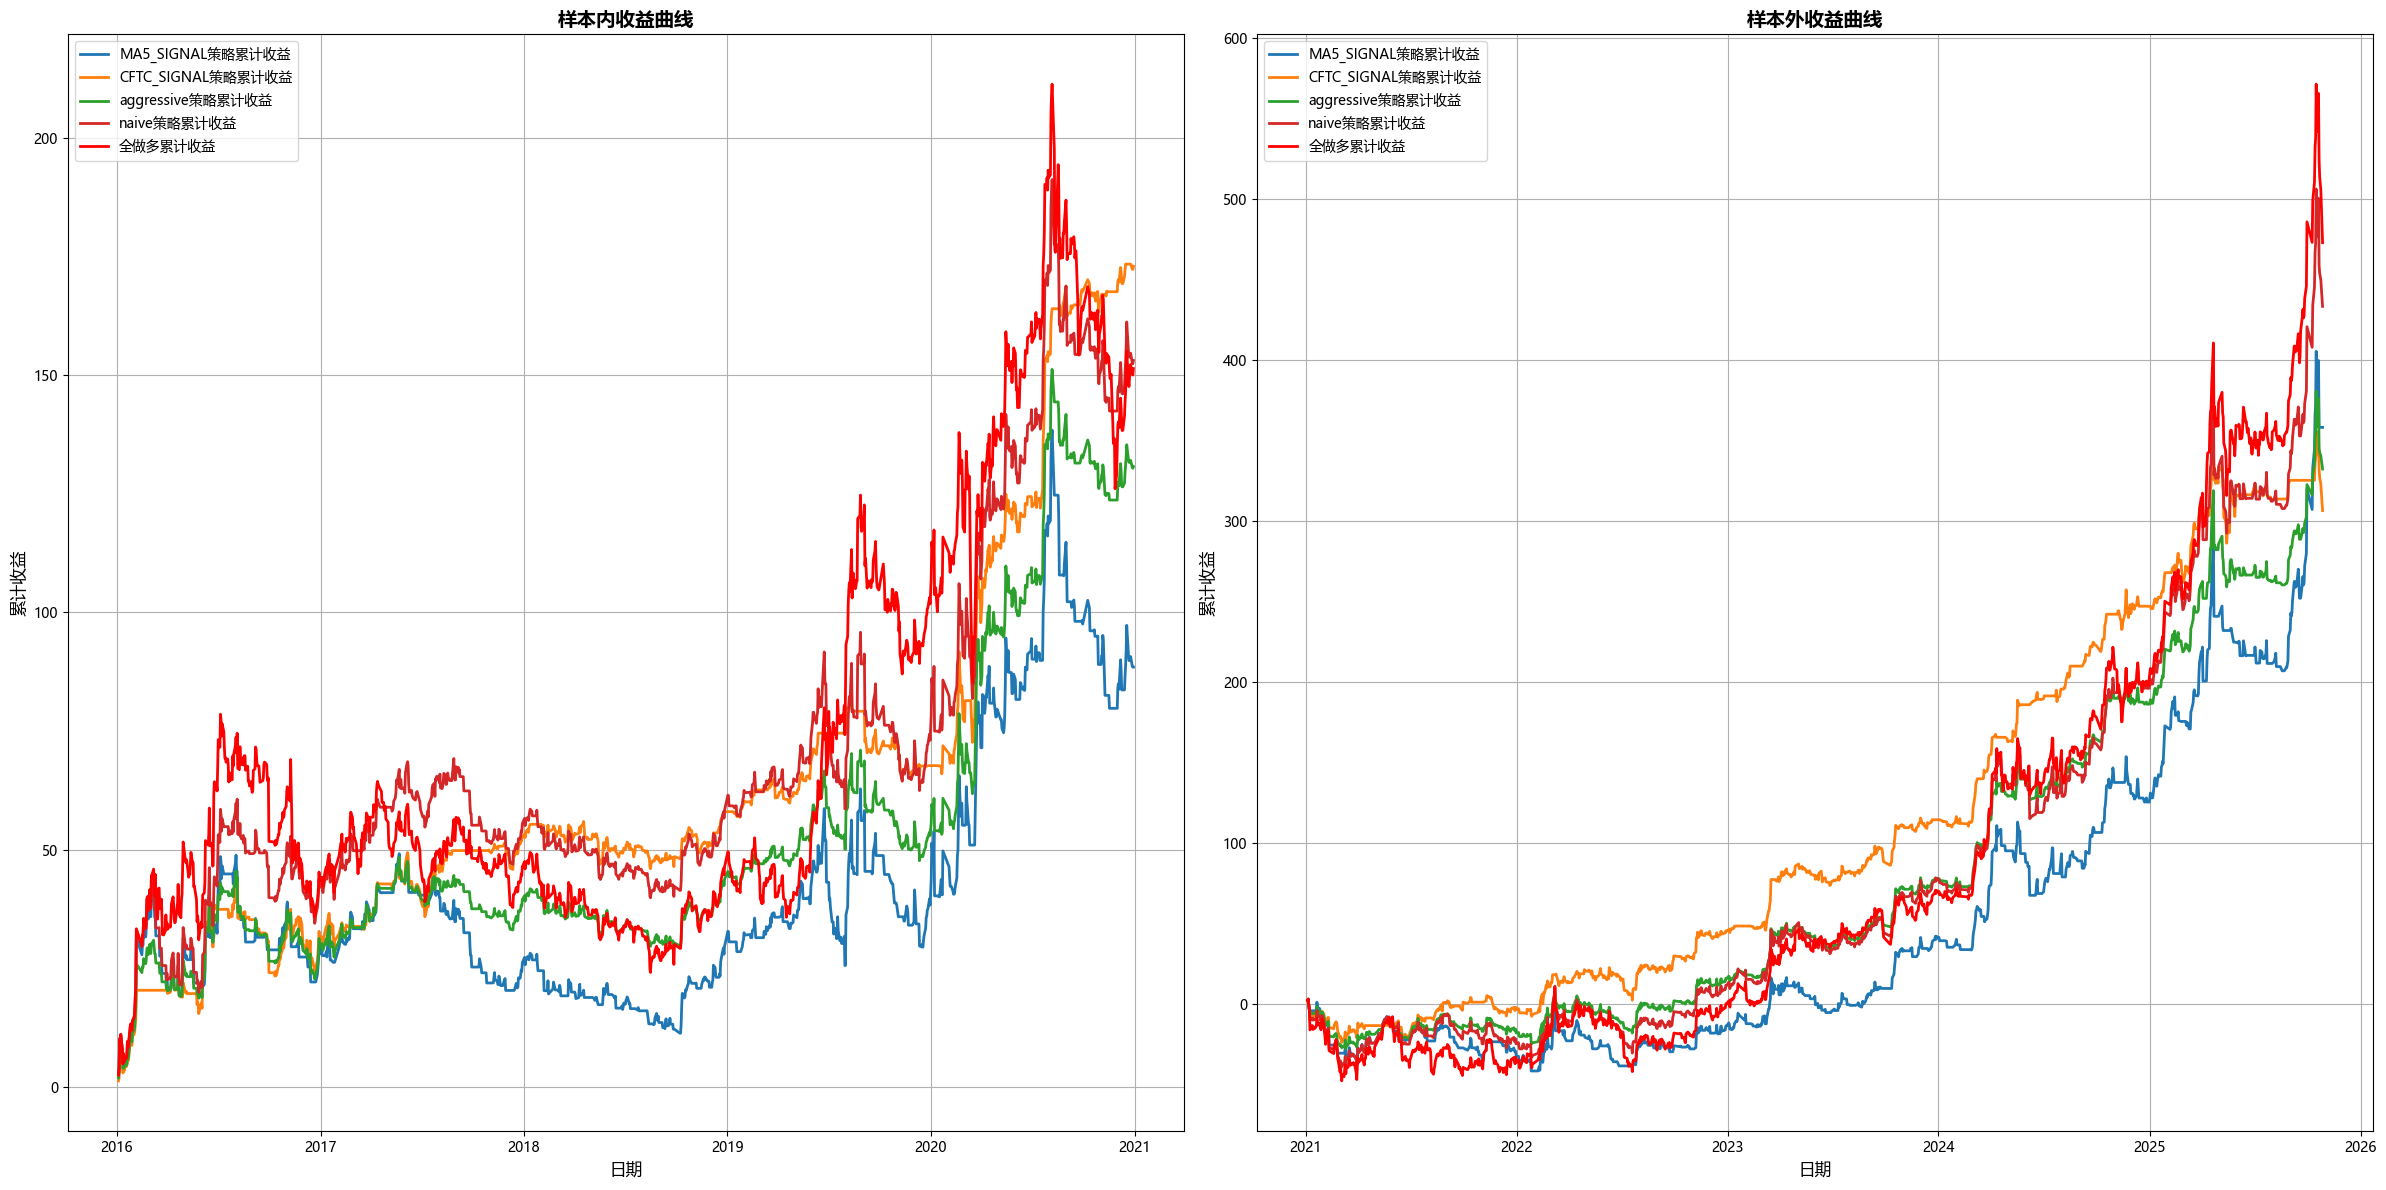

In [14]:
# 分仓逻辑重新修改，涉及到设置仓位、做多做空、信号
# 第一天的交易损益应该为0，买入的第一天没有损益，相当于上一个信号与之相反时没有损益
# 测两个激进的策略的收益表现
# 写报告，基于现有报告，以及计算：持有期收益率、年化收益率、ROA、夏普比（自定无风险利率）、卡玛比、最大回撤
# 报告逻辑：1.先写CFTC信号（没有捕捉的地方），再写MA5信号（引入联合信号），最后写综合信号的回测结果（放好的），以及组合评价
import pandas as pd
import matplotlib.pyplot as plt
# 配置 Matplotlib 使用中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置字体为微软雅黑（Windows系统）
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
# 读取数据
train_result = pd.read_excel("gold_combined.xlsx", index_col=0, sheet_name='样本内')
test_result = pd.read_excel("gold_combined.xlsx", index_col=0, sheet_name='样本外')

# 计算每日收益并累计
def calculate_returns(df, signal_columns, price_column='close'):
    # 创建一个空字典来保存每个信号的每日收益
    daily_returns_dict = {}
    
    for signal in signal_columns:
        # 计算每日收益：今天的信号 * （明天的收盘价 - 今天的收盘价）
        daily_returns_dict[signal] = (df[price_column].shift(-1) - df[price_column]) * df[signal]
    
    # 将所有信号的每日收益加入到 DataFrame 中
    for signal, daily_returns in daily_returns_dict.items():
        df[f'{signal}_daily_returns'] = daily_returns
    
    # 计算每个信号的累计收益
    for signal in signal_columns:
        df[f'{signal}_cumulative_returns'] = df[f'{signal}_daily_returns'].cumsum()

    # 计算全做多的收益（全仓持有，信号为1时进行交易）
    df['long_only_returns'] = (df[price_column].shift(-1) - df[price_column])
    df['long_only_cumulative_returns'] = df['long_only_returns'].cumsum()
    
    return df

# 对样本内和样本外分别进行回测
signal_columns = [col for col in train_result.columns if col not in ['date', 'close','MA5']]

train_result = calculate_returns(train_result, signal_columns)
test_result = calculate_returns(test_result, signal_columns)

# 绘制收益曲线
plt.figure(figsize=(24, 12))

# 绘制样本内的收益曲线
plt.subplot(1, 2, 1)
for signal in signal_columns:
    plt.plot(train_result.index, train_result[f'{signal}_cumulative_returns'], label=f'{signal}策略累计收益', linewidth=2)
    
plt.plot(train_result.index, train_result['long_only_cumulative_returns'], label='全做多累计收益', color='red', linewidth=2)
plt.title('样本内收益曲线', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('累计收益', fontsize=12)
plt.legend()
plt.grid(True)

# 绘制样本外的收益曲线
plt.subplot(1, 2, 2)
for signal in signal_columns:
    plt.plot(test_result.index, test_result[f'{signal}_cumulative_returns'], label=f'{signal}策略累计收益', linewidth=2)
    
plt.plot(test_result.index, test_result['long_only_cumulative_returns'], label='全做多累计收益', color='red', linewidth=2)
plt.title('样本外收益曲线', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('累计收益', fontsize=12)
plt.legend()
plt.grid(True)

# 显示图表
plt.tight_layout()  # 自动调整子图布局
plt.show()

# 计算指标

In [15]:
import pandas as pd
import empyrical as emp


def calculate_returns(df, signal_columns, price_column='close'):
    # 创建每日收益
    daily_returns_dict = {}
    for signal in signal_columns:
        daily_returns_dict[signal] = (df[price_column].shift(-1) - df[price_column]) / df[price_column] * df[signal]
    
    for signal, daily_returns in daily_returns_dict.items():
        df[f'{signal}_daily_returns'] = daily_returns
    
    for signal in signal_columns:
        df[f'{signal}_cumulative_returns'] = (1 + df[f'{signal}_daily_returns']).cumprod() - 1
    
    return df
def calculate_annualized_return(df, signal_columns, trading_days=252):
    annualized_return_dict = {}
    for signal in signal_columns:
        # 计算信号列的每日收益率的均值
        mean_daily_return = df[f'{signal}_daily_returns'].mean()
        # 年化收益率 = 平均日收益率 * 每年交易日数
        annualized_return_dict[signal] = mean_daily_return * trading_days
    return annualized_return_dict

# 计算各类指标
def calculate_metrics(df, signal_columns, risk_free_rate=0.02):
    metrics_dict = {}

    # 1. 持有期收益率 (Holding Period Return)
    hpr_dict = {}
    for signal in signal_columns:
        hpr_dict[signal] = (1 + df[f'{signal}_daily_returns']).prod() - 1
    metrics_dict['HPR'] = hpr_dict

    # 2. 年化收益率 (Annualized Return)
    metrics_dict['Annualized Return'] = calculate_annualized_return(df, signal_columns)

    # 3. ROA (Return on Assets)
    # 假设你有一个资产列 'assets'，ROA = 每日收益 / 资产均值
    """ArithmeticError
    roa_dict = {}
    for signal in signal_columns:
        roa_dict[signal] = df[f'{signal}_daily_returns'].mean() / df['assets'].mean()
    metrics_dict['ROA'] = roa_dict
    """
    # 4. 夏普比率 (Sharpe Ratio)
    sharpe_ratio_dict = {}
    for signal in signal_columns:
        sharpe_ratio_dict[signal] = emp.sharpe_ratio(df[f'{signal}_daily_returns'], risk_free=risk_free_rate)
    metrics_dict['Sharpe Ratio'] = sharpe_ratio_dict

    # 5. 卡玛比率 (Calmar Ratio)
    calmar_ratio_dict = {}
    for signal in signal_columns:
        mean_daily_return = df[f'{signal}_daily_returns'].mean()
        # 年化收益率 = 平均日收益率 * 每年交易日数
        annualized_return = mean_daily_return * 252
        max_drawdown = emp.max_drawdown(df[f'{signal}_daily_returns'])
        calmar_ratio_dict[signal] = annualized_return / abs(max_drawdown)
    metrics_dict['Calmar Ratio'] = calmar_ratio_dict

    # 6. 最大回撤 (Max Drawdown)
    max_drawdown_dict = {}
    for signal in signal_columns:
        max_drawdown_dict[signal] = emp.max_drawdown(df[f'{signal}_daily_returns'])
    metrics_dict['Max Drawdown'] = max_drawdown_dict

    return metrics_dict

# 计算指标
signal_columns = ['MA5_SIGNAL', 'CFTC_SIGNAL', 'aggressive', 'naive','all_long']  # 示例信号列名
test_result = pd.read_excel("gold_combined.xlsx", index_col=0, sheet_name='样本外')
train_result = pd.read_excel("gold_combined.xlsx", index_col=0, sheet_name='样本内')
test_result['all_long'] = 1
train_result['all_long'] = 1
print("样本外结果")
test_result = calculate_returns(test_result, signal_columns)

# 计算各类金融指标
metrics = calculate_metrics(test_result, signal_columns)

# 打印结果
for metric_name, metric_values in metrics.items():
    print(f"\n{metric_name}:")
    for signal, value in metric_values.items():
        print(f"  {signal}: {value:.4f}")
print("样本内结果")
train_result = calculate_returns(train_result, signal_columns)

# 计算各类金融指标
metrics = calculate_metrics(train_result, signal_columns)

# 打印结果
for metric_name, metric_values in metrics.items():
    print(f"\n{metric_name}:")
    for signal, value in metric_values.items():
        print(f"  {signal}: {value:.4f}")

样本外结果

HPR:
  MA5_SIGNAL: 0.6929
  CFTC_SIGNAL: 0.8056
  aggressive: 0.7554
  naive: 0.9913
  all_long: 1.1024

Annualized Return:
  MA5_SIGNAL: 0.1196
  CFTC_SIGNAL: 0.1305
  aggressive: 0.1251
  naive: 0.1557
  all_long: 0.1699

Sharpe Ratio:
  MA5_SIGNAL: -46.1646
  CFTC_SIGNAL: -66.8475
  aggressive: -60.3129
  naive: -42.4281
  all_long: -36.1696

Calmar Ratio:
  MA5_SIGNAL: 1.1511
  CFTC_SIGNAL: 1.7174
  aggressive: 1.7525
  naive: 1.5654
  all_long: 1.4373

Max Drawdown:
  MA5_SIGNAL: -0.1039
  CFTC_SIGNAL: -0.0760
  aggressive: -0.0714
  naive: -0.0994
  all_long: -0.1182
样本内结果

HPR:
  MA5_SIGNAL: 0.2979
  CFTC_SIGNAL: 0.6175
  aggressive: 0.4541
  naive: 0.5541
  all_long: 0.5567

Annualized Return:
  MA5_SIGNAL: 0.0590
  CFTC_SIGNAL: 0.1021
  aggressive: 0.0805
  naive: 0.0970
  all_long: 0.1004

Sharpe Ratio:
  MA5_SIGNAL: -49.7510
  CFTC_SIGNAL: -70.0977
  aggressive: -63.8950
  naive: -46.1181
  all_long: -37.2401

Calmar Ratio:
  MA5_SIGNAL: 0.4843
  CFTC_SIGNAL: 1.7812
 